In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

Load deltas in a given healpix pixel delta-healpix.fits.gz

In [39]:
deltas_path='/global/cfs/cdirs/desi/science/lya/mock_analysis/develop/ifae-ql/qq_desi_y3/v1.0.5/analysis-0/jura-124/raw_bao_unblinding/deltas_lya/Delta/'
delta_file=deltas_path+'delta-500.fits.gz' # 500 is the healpix pixel 
file = fits.open(delta_file)
num_of_skewers = len(file)-1

Choose redshift bin in which you want to measure the power spectrum

In [40]:
z_bin = 2.5
z_start = z_bin - dz/2
dz = 0.2
z_end = z_bin + dz/2
lam_lya = 1215.6 #Angstrom  
lamobs_start = lam_lya*(1+z_start)
lamobs_end = lam_lya*(1+z_end)
print(lamobs_start,lamobs_end)
pw_A  = 0.8
lamarray = np.arange(lamobs_start,lamobs_end,pw_A)

4133.04 4376.16


For each skewer, extract the deltas in the redshift range of measurement

In [45]:
extracted_deltas = []
extracted_lamobs = []
for i in range(int(num_of_skewers)):
    ihdu=i+1
    z_qso=file[ihdu].header['Z']
    lam_obs = 10.0**(file[ihdu].data['LOGLAM'])
    delta_data=file[ihdu].data['DELTA']
    if np.any(lam_obs <= lamobs_start) and np.any(lam_obs >= lamobs_end):
        # Extract only the valid range
        filtered_deltas = delta_data[(lam_obs >= lamobs_start) & (lam_obs <= lamobs_end)]
        extracted_deltas.append(filtered_deltas)
        filtered_lamobs = lam_obs[(lam_obs >= lamobs_start) & (lam_obs <= lamobs_end)]
        extracted_lamobs.append(filtered_lamobs)
        #print(filtered_lamobs)
        #print(ihdu)
        #plt.plot(lam_obs,delta_data)
        #plt.plot(filtered_lamobs,filtered_deltas)
extracted_deltas = np.array(extracted_deltas)   
extracted_lamobs = np.array(extracted_lamobs) 
print(np.shape(extracted_deltas))
print('number of sightlines in the given redshift bin:',len(extracted_deltas[:,0]))
N_skewers = len(extracted_deltas[:,0])

(200, 304)
number of sightlines in the given redshift bin: 200


Fourier transform of deltas 

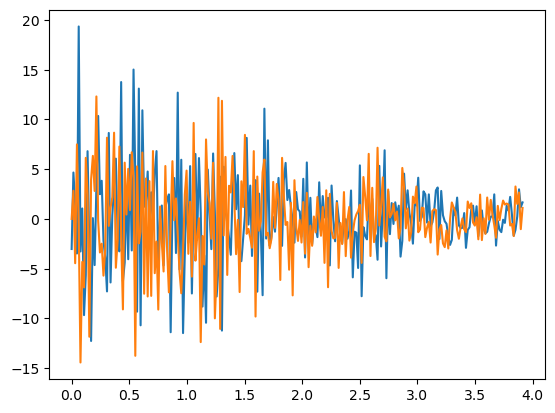

In [42]:
N_FFT  = 512
k_arr = np.fft.fftfreq(N_FFT)*2*np.pi/pw_A
#print(k_arr[:N_FFT//2])
delta_ft = np.zeros((len(extracted_deltas[:,0]),len(extracted_deltas[0,:])))
pad_ft  = np.zeros((len(extracted_deltas[:,0]),N_FFT),dtype=np.complex64)
padded_deltas = np.pad(extracted_deltas, pad_width=((0, 0), (0, N_FFT - len(extracted_deltas[0,:]))), mode='constant')

for l in range(len(extracted_deltas[:,0])):
    pad_ft[l,:] = np.fft.fft(padded_deltas[l,:])

plt.plot(k_arr[:N_FFT//2],pad_ft.real[0,:N_FFT//2])
plt.plot(k_arr[:N_FFT//2],pad_ft.imag[0,:N_FFT//2])

Average power spectrum in the given redshift bin 

In [43]:
p1d_km = pw_A/N_FFT*1/N_skewers*np.sum(np.abs(pad_ft)**2,axis=0) # Ignored the resolution function R_a(x)

Text(0.5, 1.0, 'Average 1D PS at z=2.50')

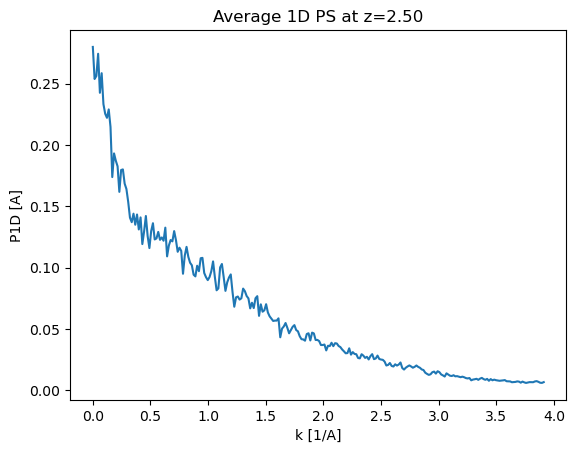

In [44]:
plt.plot(k_arr[:N_FFT//2],p1d_km[:N_FFT//2])
plt.xlabel('k [1/A]')
plt.ylabel('P1D [A]')
plt.title('Average 1D PS at z=%0.2f'%z_bin)